<a href="https://colab.research.google.com/github/Polinez/ImageClassification/blob/main/Klasyfikacja_Pokemonow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Przygotowanie bazy danych
pobieramy baze z dysku google ktora jest juz posortowana na podkatalogi

In [1]:
#instalacja pakietu gdown
!pip install -U --no-cache-dir gdown --pre

#usuwanie i tworzenie pustego katalogu data
!rm -rf data && rm -rf content && mkdir data

#pobieranie zip-a ze zdjęciami
!gdown 1B2VsNDlaKiND2qa_pzJnXaygihHSUcGH -O data.zip

#rozpakowywanie pliku data.zip do katalogu data
!unzip -q data.zip

Downloading...
From (original): https://drive.google.com/uc?id=1B2VsNDlaKiND2qa_pzJnXaygihHSUcGH
From (redirected): https://drive.google.com/uc?id=1B2VsNDlaKiND2qa_pzJnXaygihHSUcGH&confirm=t&uuid=8d4ba526-289b-42c8-a07a-5a75de6282e5
To: /content/data.zip
100% 411M/411M [00:11<00:00, 35.6MB/s]


# Pobranie potrzebnych bibliotek oraz wizualizacja jakie dane posiadamy


## Biblioteki


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import os


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

## Ilosc zdjec

In [3]:
image_count = len(list(glob.glob('data/**/*.png')))
print(f'{image_count} examples of pokemons')

26539 examples of pokemons


## Ilosc poszczegolnej klasy

In [4]:
folder_counts = dict()


for file_path in glob.glob('data/**/*.png', recursive=True):

    folder_name = os.path.basename(os.path.dirname(file_path))
    folder_counts[folder_name] = folder_counts.get(folder_name, 0) + 1


for folder, count in folder_counts.items():
    print(f'{count} examples of {folder}')

6 examples of fuecoco
38 examples of wingull
20 examples of klefki
6 examples of dudunsparce-two-segment
40 examples of pichu
6 examples of nacli
40 examples of electrode
13 examples of dreepy
16 examples of sandygast
38 examples of swellow
6 examples of enamorus-incarnate
40 examples of murkrow
20 examples of goomy
6 examples of meowscarada
40 examples of dodrio
40 examples of nidorina
20 examples of gigalith
6 examples of iron-thorns
6 examples of scovillain
20 examples of mienfoo
20 examples of eelektross
38 examples of corphish
40 examples of mr-mime
38 examples of slakoth
20 examples of darmanitan-standard
40 examples of croconaw
20 examples of pidove
32 examples of riolu
40 examples of mew
40 examples of golbat
40 examples of ledyba
16 examples of naganadel
16 examples of rowlet
18 examples of pangoro
40 examples of sunflora
40 examples of natu
32 examples of infernape
13 examples of mr-rime
32 examples of togekiss
6 examples of dachsbun
40 examples of cyndaquil
20 examples of gu

## Wyswietlenie przykłądowego zdjecia

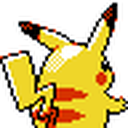

In [5]:
pikachu = list(glob.glob('data/pikachu/*'))
PIL.Image.open(str(pikachu[15]))

# Uczenie modelu

In [6]:
batch_size = 16 # liczba obrazow na raz

img_height = 128 # rozmiar obrazu po skalowaniu
img_width = 128

## Podział modelu na treninogowy i sprawdzajacy w proporccji 80 do 20

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26539 files belonging to 1000 classes.
Using 21232 files for training.
Found 26539 files belonging to 1000 classes.
Using 5307 files for validation.


In [8]:
class_names = train_ds.class_names
class_count = len(class_names)
print(f'class names: {class_names}')

class names: ['abomasnow', 'abra', 'absol', 'accelgor', 'aegislash-shield', 'aerodactyl', 'aggron', 'aipom', 'alakazam', 'alcremie', 'alomomola', 'altaria', 'amaura', 'ambipom', 'amoonguss', 'ampharos', 'annihilape', 'anorith', 'appletun', 'applin', 'araquanid', 'arbok', 'arboliva', 'arcanine', 'arceus', 'archen', 'archeops', 'arctibax', 'arctovish', 'arctozolt', 'ariados', 'armaldo', 'armarouge', 'aromatisse', 'aron', 'arrokuda', 'articuno', 'audino', 'aurorus', 'avalugg', 'axew', 'azelf', 'azumarill', 'azurill', 'bagon', 'baltoy', 'banette', 'barbaracle', 'barboach', 'barraskewda', 'basculegion-male', 'basculin-red-striped', 'bastiodon', 'baxcalibur', 'bayleef', 'beartic', 'beautifly', 'beedrill', 'beheeyem', 'beldum', 'bellibolt', 'bellossom', 'bellsprout', 'bergmite', 'bewear', 'bibarel', 'bidoof', 'binacle', 'bisharp', 'blacephalon', 'blastoise', 'blaziken', 'blipbug', 'blissey', 'blitzle', 'boldore', 'boltund', 'bombirdier', 'bonsly', 'bouffalant', 'bounsweet', 'braixen', 'brambl

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Definiujemy modele

In [10]:
def get_model(type='resnet_transfer'):
  model = None
  if type == 'resnet_transfer':
    base_model = tf.keras.applications.ResNet50(
            include_top=False,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )
    x = layers.GlobalAveragePooling2D()(base_model.output)

    # Add a fully connected layer with a sigmoid activation for binary classification
    predictions = layers.Dense(class_count, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

  elif type == 'resnet':
    model = tf.keras.applications.ResNet50(
            weights=None,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )

  elif type == 'custom':
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(class_count)
    ])

  return model


## Wybor i kompilownie modelu

In [11]:
model = get_model('custom')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │         129,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,249,864 (8.58 MB)

 Trainable params: 2,249,864 (8.58 MB)

 Non-trainable params: 0 (0.00 B)

## Trenowanie

In [12]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.0081 - loss: 6.6708 - val_accuracy: 0.1001 - val_loss: 5.3119
Epoch 2/20
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2380 - loss: 4.2053 - val_accuracy: 0.4451 - val_loss: 3.1289
Epoch 3/20
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6480 - loss: 1.7005 - val_accuracy: 0.6116 - val_loss: 2.3001
Epoch 4/20
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8429 - loss: 0.7119 - val_accuracy: 0.6848 - val_loss: 2.1380
Epoch 5/20
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9077 - loss: 0.3855 - val_accuracy: 0.7217 - val_loss: 2.1781
Epoch 6/20
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9397 - loss: 0.2380 - val_accuracy: 0.7330 - val_loss: 2.4683
Epoch 7/20
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9480 - loss: 0.1967 - val_accuracy: 0.7315 - val_loss: 2.8120
Epoch 8/20
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9596 - loss: 0.1386

## Wyswietlanie wynikow

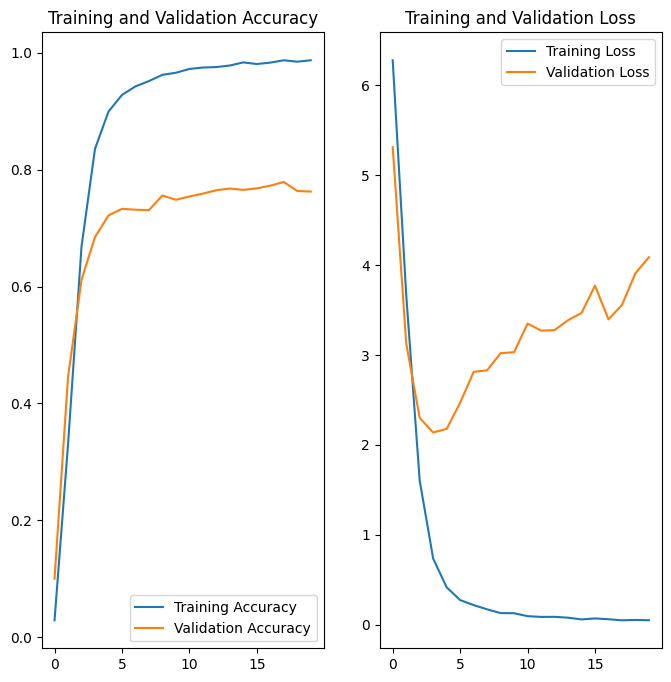

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
from sklearn.metrics import classification_report
def evaluate_model(val_ds, model):
    y_pred = []
    y_true = []

    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred = y_pred + np.argmax(tf.nn.softmax(predictions), axis=1).tolist()
        y_true = y_true + batch_labels.numpy().tolist()
    print(classification_report(y_true, y_pred))

evaluate_model(val_ds, model)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      0.58      0.74        12
           2       0.62      0.71      0.67         7
           3       0.00      0.00      0.00         2
           4       0.43      1.00      0.60         3
           5       0.79      1.00      0.88        11
           6       1.00      1.00      1.00         3
           7       0.50      0.75      0.60         4
           8       0.88      0.78      0.82         9
           9       0.50      0.67      0.57         3
          10       0.50      0.67      0.57         3
          11       0.62      0.71      0.67         7
          12       0.67      0.50      0.57         4
          13       0.89      1.00      0.94         8
          14       0.40      1.00      0.57         2
          15       0.67      0.25      0.36         8
          16       0.67      1.00      0.80         2
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_